In [2]:
%matplotlib widget
import sys
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/')
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/.ipynb_checkpoints')
sys.path.append('/home/massoale/Stage_M2/Analyse/qgutils-master/')
sys.path.append('/home/massoale/Bureau/Stage_M2/stage_diags/diagnostics_pkg/')
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import io_utils as io
import operators as op
import qgutils as qg
import xarray as xr
import scipy as sp
import dask.array as da
from joblib import Parallel, delayed

la simulation chargée est: dahu_517
depuis: dahu_downsized


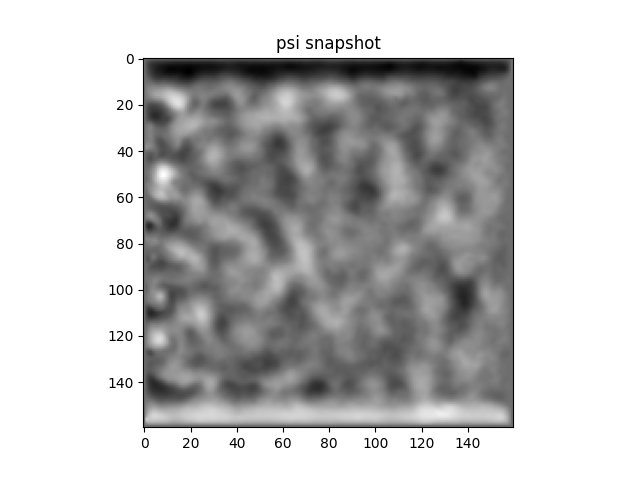

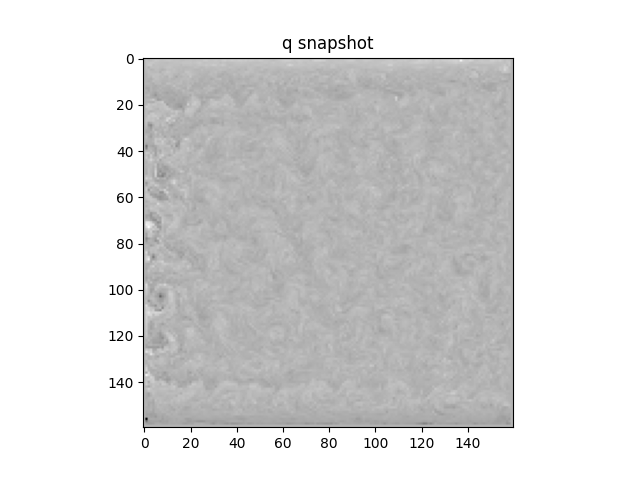

In [9]:



# Number of simulation
n = 517

# Choose between 'local' or 'dahu' or 'dahu_downsized'
where = 'dahu_downsized'

# Reading the netcdf file
if where == 'local':
    if n < 10:
        simu_name = 'outdir_000' + str(n)
    elif n < 100 and n >= 10:
        simu_name = 'outdir_00' + str(n)
    Path = '/home/massoale/Simu_Test/qgw-main/src/' + simu_name + '/'
elif where == 'dahu':
    simu_name = 'dahu_' + str(n)
    Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

elif where == 'dahu_downsized':
    simu_name = 'dahu_' + str(n)
    Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_downsized/'
    Path_bis = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

else:
    print('Error: where not recognized')
    sys.exit()

print('la simulation chargée est: ' + simu_name)
print("depuis: " + where)

filenames = ['/vars.nc']

# Open the dataset using xarray
#dataset = xr.open_dataset(Path + filenames[0],chunks={'time': 10})
dataset=nc.Dataset(Path+filenames[0])

# # Load variables in chunks
# t = dataset['time'].data
# x = dataset['x'].data
# y = dataset['y'].data
# psi = dataset['psi'].isel(level=0).data
# q = dataset['q'].isel(level=0).data
# print("shape of psi :",np.shape(psi))


t=dataset.variables['time'][:]
x=dataset.variables['x'][:]
y=dataset.variables['y'][:]
psi=dataset.variables['psi'][:,0,:,:]
q=dataset.variables['q'][:,0,:,:]
# plot example snapshots
plt.figure()
plt.imshow(psi[1,:,:], cmap = "grey")
plt.title("psi snapshot")
plt.show()
plt.imshow(q[1,:,:], cmap = "grey")
plt.title("q snapshot")
plt.show()
if where == 'dahu_downsized':
    param = io.read_params(Path_bis)
    nx = 256
    ny = 256
    
    param['NX'] = nx
    param['NY'] = ny
else:
    param = io.read_params(Path)
    nx = int(param['NX'])
    ny = int(param['NY'])

f0 = param['f0']
beta = param['beta']
hEkb = param['hEkb']
dh = param['dh'][0]
Lx = param['Lx']
k_f = param['k_f']
sigma_f = param['sigma_f']
bc_fac = param['bc_fac']
nu_hyper = param['nu_hyper']
n_hyper = param['n_hyper']
dt_out = param['dt_out']

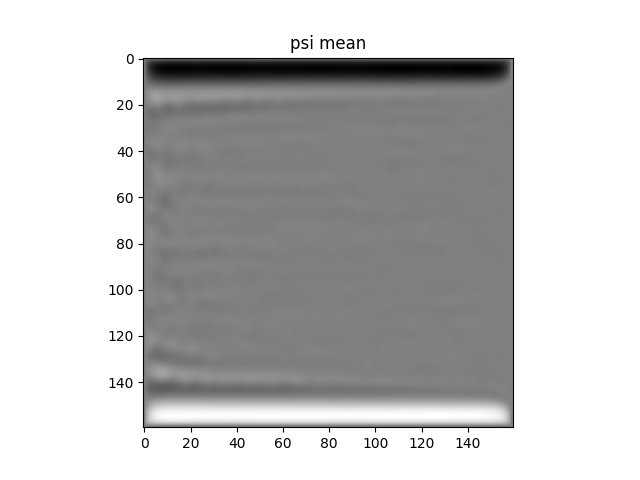

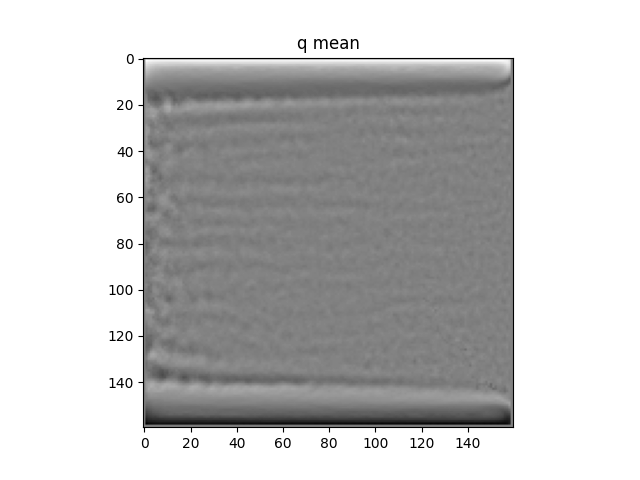

In [10]:
psi_mean = np.mean(psi, axis = 0)
q_mean = np.mean(q, axis = 0)
plt.figure()
# plot means
plt.imshow(psi_mean, cmap = "grey")
plt.title("psi mean")
plt.show()
plt.imshow(q_mean, cmap = "grey")
plt.title("q mean")
plt.show()

In [11]:
# vectorized functions to project and recreate wave fields

def project_basin_vec(q, ms, ns, L, norm = 0):
    ''' gives back complex amplitude that describes the projection of the field q onto the basin mode n,m. Projection on q gives the energy (in which case norm = 1 gives the proper normalisation), but works on any field.'''
    
    N  = np.shape(q)[-1]
    
    X = np.linspace(0, L, N)
    Y = np.linspace(0, L, N)
    x, y = np.meshgrid(X, Y)
    
    mode = np.exp(-1j*np.pi*np.sqrt(ms[:,:,None,None]**2 + ns[:,:,None,None]**2)*x[None,None,:,:]/L)*np.sin(ms[:,:,None,None]*np.pi*x[None,None,:,:]/L)*np.sin(ns[:,:,None,None]*np.pi*y[None,None,:,:]/L)
    
    delta = L/(N-1)
    
    if norm:
        coeff_mn = (-np.pi**2*(ns[:,:,None,None]**2 + ms[:,:,None,None]**2)/4)*(mode*q[None,None,:,:]).sum(axis = (-2,-1))*delta**2
    else:
        coeff_mn = (mode*q[None,None,:,:]).sum(axis = (-2,-1))*delta**2
        
    return coeff_mn

def build_basin_vec(ms, ns, Amp, phi, N, beta, L):
    ''' gives back the non-normalised n/m basin mode at phase phi. m and n are the zonal and meridional wavenumbers respectively, and N the number of grid points.'''
    
    X = np.linspace(0, L, N)
    Y = np.linspace(0, L, N)
    x, y = np.meshgrid(X, Y)
    
    lam = 2*np.pi*np.sqrt(ns**2 + ms*2)
    sigma = beta*L/(2*np.pi*np.sqrt(ns**2+ms**2))
    
    # Psi interior
    pi = np.pi
    psi = Amps[:,:,None,None]*np.cos(phi[:,:,None,None] + (beta * x[None,None,:,:]) / (2 * sigma[:,:,None,None])) * np.sin((ms[:,:,None,None] * pi * x[None,None,:,:]) / L) * np.sin((ns[:,:,None,None] * pi * y[None,None,:,:]) / L)
    
    # q interior
    
    q = -Amp[:,:,None,None]*(
            (
                (beta**2 * L**2 + 4 * (ms[:,:,None,None]**2 + ns[:,:,None,None]**2) * pi**2 * sigma[:,:,None,None]**2) * np.cos(phi[:,:,None,None] + (beta * x[None,None,:,:]) / (2 * sigma[:,:,None,None])) * np.sin((ms[:,:,None,None] * pi * x[None,None,:,:]) / L) +
                4 * beta * L * ms[:,:,None,None] * pi * sigma[:,:,None,None] * np.cos((ms[:,:,None,None] * pi * x[None,None,:,:]) / L) * np.sin(phi[:,:,None,None] + (beta * x[None,None,:,:]) / (2 * sigma[:,:,None,None]))
            ) * np.sin((ns[:,:,None,None]* pi * y[None,None,:,:]) / L)
        ) / (4 * L**2 * sigma[:,:,None,None]**2)

    psi = np.sum(psi, axis = (0,1))
    q = np.sum(q, axis = (0,1))
    
    return psi, q

In [12]:
# project on certain n and ms and reconstruct everything underneath n_rhines

n_rhines = 10

nn = 20 # total number of ns to test
nm = 20 # total number of ms to test
i = 20 # time index of snapshot to discect

L=Lx

ns = np.linspace(1, nn, nn)
ms = np.linspace(1, nm, nm)
Ms, Ns = np.meshgrid(ms, ns)

coeff_mn = project_basin_vec(q[i,:,:] - q_mean, Ms, Ns, L)
coeff_mn /= -np.pi**2*((Ms)**2 + (Ns)**2)/4
phis = np.arctan2( np.imag(coeff_mn), np.real(coeff_mn))
Amps = np.abs(coeff_mn)


Amp_sel = np.zeros_like(Amps)

for n in ns:
    for m in ms:
        n = int(n)
        m = int(m)
        if np.sqrt(n**2 + m**2) < 10:
            Amp_sel[n-1,m-1] = Amps[n-1,m-1]
            
N = len(psi[0,0,:])
psi_basin, q_basin = build_basin_vec(Ms, Ns, Amp_sel, phis, N, beta, L)

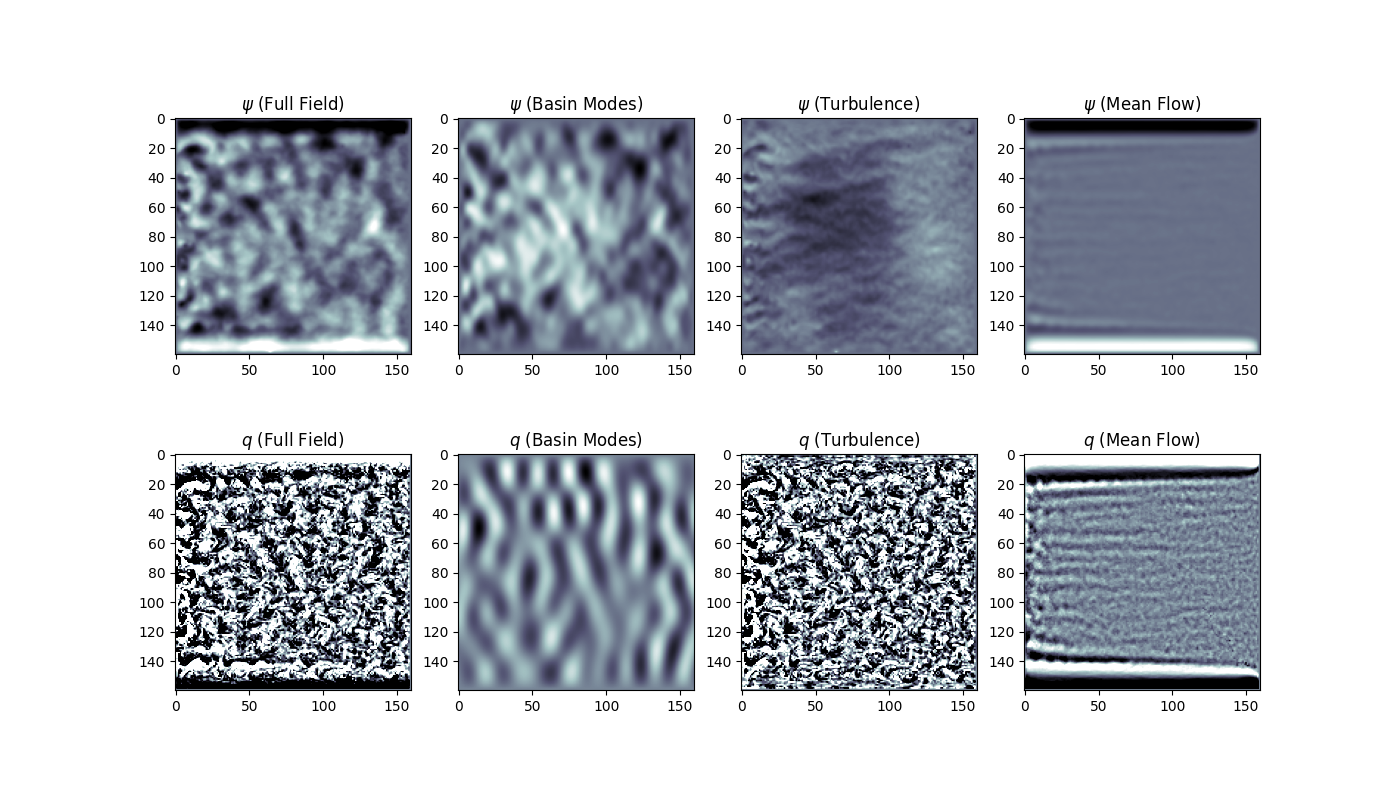

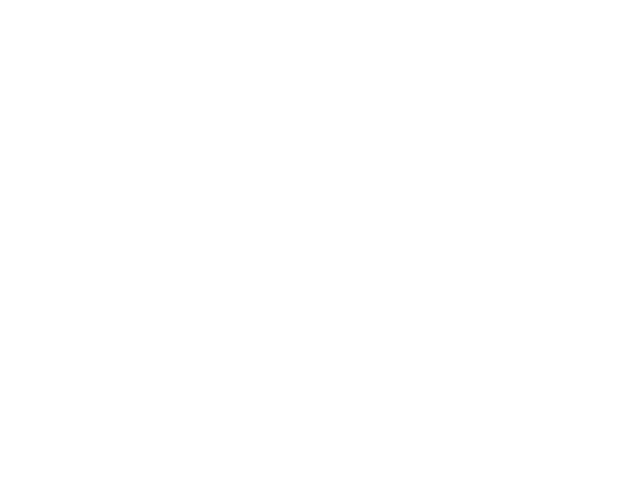

In [13]:

cmap = "bone"
plt.figure()
fig, axes = plt.subplots(2,4, figsize = (14,8))

ax = axes[0,0]
ax.set_title(r"$\psi$ (Full Field)")
ax.imshow(psi[i,:,:], vmin = np.min(psi_basin), vmax = np.max(psi_basin), cmap = cmap)
ax = axes[0,1]
ax.set_title(r"$\psi$ (Basin Modes)")
ax.imshow(psi_basin, vmin = np.min(psi_basin), vmax = np.max(psi_basin), cmap = cmap)
ax = axes[0,2]
ax.set_title(r"$\psi$ (Turbulence)")
cplot = ax.imshow(psi[i,:,:] - psi_basin - psi_mean, vmin = np.min(psi_basin), vmax = np.max(psi_basin), cmap = cmap)
ax = axes[0,3]
ax.set_title(r"$\psi$ (Mean Flow)")
cplot = ax.imshow(psi_mean, vmin = np.min(psi_basin), vmax = np.max(psi_basin), cmap = cmap)

ax = axes[1,0]
ax.set_title(r"$q$ (Full Field)")
ax.imshow(q[i,:,:], vmin = np.min(q_basin), vmax = np.max(q_basin), cmap = cmap)
ax = axes[1,1]
ax.set_title(r"$q$ (Basin Modes)")
ax.imshow(q_basin, vmin = np.min(q_basin), vmax = np.max(q_basin), cmap = cmap)
ax = axes[1,2]
ax.set_title(r"$q$ (Turbulence)")
cplot = ax.imshow(q[i,:,:] - q_basin - q_mean, vmin = np.min(q_basin), vmax = np.max(q_basin), cmap = cmap)
ax = axes[1,3]
ax.set_title(r"$q$ (Mean Flow)")
cplot = ax.imshow(q_mean, vmin = np.min(q_basin), vmax = np.max(q_basin), cmap = cmap)
plt.show()